In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [2]:
data = keras.datasets.fashion_mnist
(tx,ty) , (testx,testy) = data.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
import pandas as pd

#get the train/test split package from skelearn for preparing our dataset to train and test the model with
from sklearn.model_selection import train_test_split

#Import the numpy library to work with and manipulate the data
import numpy as np

# New Section

In [4]:
dataset = pd.read_csv('/content/dataset.csv')

dataset = dataset.dropna()

print('first rows:')
dataset.head()

first rows:


,longitude,latitude,m_age,total_rooms,total_bedrooms,population,households,median_income,median_house_val,y
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,NEAR BAY


California Housing


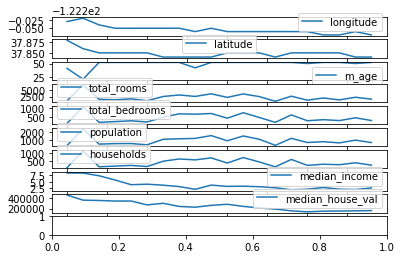

In [6]:
import matplotlib.pyplot as plt
columns = dataset.columns.drop(['y'])
rows = dataset.head(20)
fig, ax = plt.subplots(nrows=10, ncols=1)
data = range(0,rows.shape[0])
index=0
# Plot the feature subplots for given housing dataset
# Each feature will be having a seperate subplot
print('California Housing')
for column in columns:
  ax[index].plot(data, rows[column], label=column)
  ax[index].legend()
  index=index+1


# New Section

In [0]:
import sklearn


#will predict the median house value column
Y = dataset['median_house_val']

#selecting from longitude column to median column
X= dataset.loc[:,'longitude':'median_income']

#X = sklearn.preprocessing.normalize(X)

#spliting the dataset into training and testing
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size = 0.3)

#converting the datasets into numpy arrays to work with our Pytorch model
x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()

#converting the testing datasets into numpy arrays
x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

In [0]:
import torch

#import the 1D convolution layer since it is tabular data or sequence data
from torch.nn import Conv1d

#import the max pooling layer
from torch.nn import MaxPool1d

#import the flatten layer
from torch.nn import Flatten

#import the linear layer
from torch.nn import Linear

#import the relu activation function
from torch.nn.functional import relu

#import the relu activation function
from torch.nn import BatchNorm1d


#import the dataloader and tensordataset libraries from pytorch to work with out datasets
#dataloader will take tensor dataset as ip and out the batch size
from torch.utils.data import DataLoader, TensorDataset

In [0]:


# passing module will help us use the parameters
class CnnRegressor(torch.nn.Module):

  def __init__(self, batch_size,inputs,outputs):
    super(CnnRegressor,self).__init__()
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs

    self.input_layer = Conv1d(inputs,batch_size,1)
    self.batch_normalization = BatchNorm1d(batch_size)
    self.max_pooling_layer = MaxPool1d(1)

    self.conv_layer = Conv1d(batch_size,128,1)
    self.batch_normalization2 = BatchNorm1d(128)
    self.max_pooling_layer2 = MaxPool1d(1)


    self.flatten_layer = Flatten()
 
    #define a linear layer (ips,opts)
    self.linear_layer = Linear(128,64)

    #define the output layer
    self.output_layer = Linear(64,outputs)

  def feed(self,input):
    input = input.reshape((self.batch_size,self.inputs,1))

    output = relu(self.batch_normalization(self.input_layer(input)))

    output = self.max_pooling_layer(output)

    output = relu(self.batch_normalization2(self.conv_layer(output)))

    output = self.flatten_layer(output)

    output = self.linear_layer(output)

    output = self.output_layer(output)
    return output




In [10]:
from torch.optim import  SGD

from torch.nn import L1Loss

!pip install pytorch.ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

     |████████████████████████████████| 112kB 5.1MB/s 


In [11]:
batch_size = 64

model = CnnRegressor(batch_size,X.shape[1],1)

model.cuda()

CnnRegressor(
  (input_layer): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
  (batch_normalization): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (batch_normalization2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pooling_layer2): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [0]:

def model_loss(model,dataset,train = False, optimizer = None):
  performance = L1Loss()
  score_metric = R2Score()
  avg_loss = 0
  avg_score = 0
  count = 0

  for input,output in iter(dataset):
    predictions = model.feed(input)

    loss = performance(predictions,output)

    score_metric.update([predictions,output])
    score = score_metric.compute()

    if(train):
      #clear any errors so they dont cummulate
      optimizer.zero_grad()

      loss.backward()

      #use the optimizer to update the models parameters based on the gradients
      optimizer.step()

    avg_loss += loss.item()
    avg_score += score
    count += 1

  return avg_loss/count, avg_score/count



In [0]:
epochs = 500

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

inputs = torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0], 1)).cuda().float()

tensor = TensorDataset(inputs,outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)

for epoch in range(epochs):
  avg_loss, avg_r2_score = model_loss(model, loader, train=True, optimizer=optimizer)

  print("Epoch " + str(epoch+1) + ":\n\tLoss = " + str(avg_loss) + "\n\tR2 score = " + str(avg_r2_score))

In [14]:
inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0], 1)).cuda().float()

tensor = TensorDataset(inputs,outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)

#output the average performance of the model
avg_loss, avg_r2_score = model_loss(model,loader)
print("the model's L1 loss is " + str(avg_loss))
print("the model's R2 score is " + str(avg_r2_score))

the model's L1 loss is 56601.42116477273
the model's R2 score is 0.6570957535971829


In [18]:
trainedmodel = {'model': CnnRegressor(64,8,1),
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict()}
torch.save(trainedmodel, '1102484_1dconv_reg')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CnnRegressor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# New Section